### New methodology wind speed -> wind power generation ###

Instead of using a model of a model type approach, instead apply Hannah's model for wind power generation directly.

In [1]:
import os
import sys
import glob
import time

import numpy as np
import matplotlib.pyplot as plt
import iris
import cartopy.crs as ccrs

from tqdm import tqdm

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Imports from Hannah's functions
sys.path.append("/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/")

from European_hourly_hub_height_winds_2023_model import (
    country_mask,
    load_power_curves,
    load_wind_farm_location,
    load_wind_speed_and_take_to_hubheight,
    convert_to_wind_power
)

In [3]:
# ------------------------------
# Load in the ERA5 data
# ------------------------------

# Set up the path of the test file
test_file_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_test_1960_1961.nc"

# if the file exists then load in with iris
if os.path.exists(test_file_path):
    print(f"Loading test file from {test_file_path}")
    cube = iris.load_cube(test_file_path)

Loading test file from /gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_test_1960_1961.nc


In [4]:
# -----------------------------------------------
# Load in the DePreSys test file (for regridding)
# -----------------------------------------------

test_file_path = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1961-r9i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r9i1p1f2_gn_19720101-19720330.nc"

if os.path.exists(test_file_path):
    print(f"Loading DePreSys test file from {test_file_path}")
    cube_depresys = iris.load_cube(test_file_path)

Loading DePreSys test file from /badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1961-r9i1p1f2/day/sfcWind/gn/files/d20200417/sfcWind_day_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r9i1p1f2_gn_19720101-19720330.nc


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'sfcWind'
  warnings.warn(


In [5]:
# ----------------------
# Make sure the cubes are on the same grid
# ----------------------

cube = cube.intersection(
    longitude=(-180, 180), latitude=(0, 90)
)

cube_depresys = cube_depresys[0, :, :]

cube_depresys = cube_depresys.intersection(
    longitude=(-180, 180), latitude=(0, 90)
)

In [6]:
# Europe grid to subset to
eu_grid = {
    "lon1": -40,  # degrees east
    "lon2": 30,
    "lat1": 30,  # degrees north
    "lat2": 80,
}

# Subset the ERA5 cube to the European grid
cube = cube.intersection(
    longitude=(eu_grid["lon1"], eu_grid["lon2"]),
    latitude=(eu_grid["lat1"], eu_grid["lat2"]),
)

# Subset the DePreSys cube to the European grid
cube_depresys = cube_depresys.intersection(
    longitude=(eu_grid["lon1"], eu_grid["lon2"]),
    latitude=(eu_grid["lat1"], eu_grid["lat2"]),
)

In [7]:
values_tes = cube.data

In [8]:
print("Mean of values_tes:", np.mean(values_tes))
print("Minimum of values_tes:", np.min(values_tes))
print("Maximum of values_tes:", np.max(values_tes))

Mean of values_tes: 6.2381783
Minimum of values_tes: 0.051322978
Maximum of values_tes: 28.63279


In [9]:
cube_depresys_vals = cube_depresys.data

print("Mean of cube_depresys_vals:", np.mean(cube_depresys_vals))
print("Minimum of cube_depresys_vals:", np.min(cube_depresys_vals))
print("Maximum of cube_depresys_vals:", np.max(cube_depresys_vals))

Mean of cube_depresys_vals: 8.659449
Minimum of cube_depresys_vals: 0.21431732
Maximum of cube_depresys_vals: 24.792824


In [10]:
# ----------------------
# regrid the ERA5 data to the DePreSys grid
# ----------------------

cube_regridded = cube.regrid(cube_depresys, iris.analysis.Linear())

In [11]:
# -------------------------
# Any values which are negative, set to zero
# -------------------------

cube_regridded.data[cube_regridded.data < 0] = 0

In [12]:
# -----------------------
# Load the power curves
# -----------------------
onshore_pc_path = "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/power_onshore.csv"
offshore_pc_path = "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/power_offshore.csv"

pc_winds, pc_power_onshore, pc_power_offshore = load_power_curves(
    path_onshore_curve=onshore_pc_path,
    path_offshore_curve=offshore_pc_path
)

In [13]:
cube_regridded.var_name

'si10'

In [14]:
# -----------------------
# Make a country mask for the UK
# -----------------------
data_dir = "/gws/nopw/j04/canari/users/benhutch/ERA5/"
test_str = "ERA5_wind_test_1960_1961.nc"

# Test Hannah's country mask function
MASK_MATRIX_RESHAPE, LONS, LATS = country_mask(
    dataset=cube_regridded,
    COND="si10",
    COUNTRY="United Kingdom",
)

In [15]:
cube_regridded.shape

(731, 91, 85)

In [16]:
# print the number of 1s in the mask matrix
print(f"Number of 1s in the mask matrix: {np.sum(MASK_MATRIX_RESHAPE)}")

# print te total no. of grid points in the mask matrix
print(f"Total number of grid points in the mask matrix: {MASK_MATRIX_RESHAPE.size}")

Number of 1s in the mask matrix: 71.0
Total number of grid points in the mask matrix: 7735


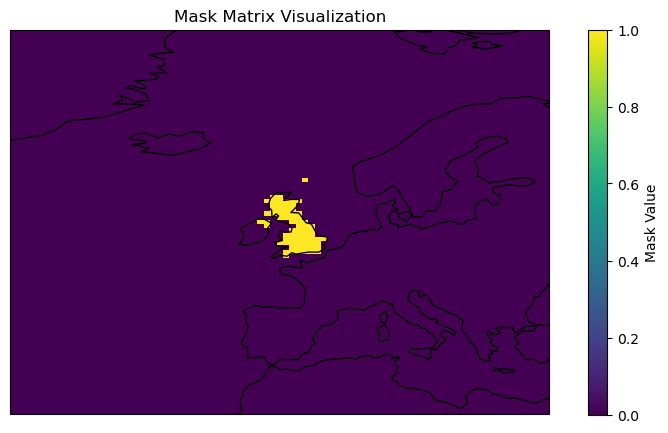

In [17]:
# ---------------------------
# Plot the mask matrix to check
# ---------------------------

plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree())  # Set the projection
ax.coastlines()  # Add coastlines for context

mesh = ax.pcolormesh(
    LONS, LATS, MASK_MATRIX_RESHAPE,
    cmap="viridis", vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system of the data
)

plt.colorbar(mesh, ax=ax, orientation="vertical", label="Mask Value")
plt.title("Mask Matrix Visualization")
plt.show()

In [59]:
# ------------------------------------------------------------------
# Load in the UK wind farm locations and process area weighted means
# ------------------------------------------------------------------

path_to_farm_locations_ons = (
    "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/United_Kingdomwindfarm_dist_ons_2021.nc"
)
path_to_farm_locations_ofs = (
    "/home/users/benhutch/for_martin/for_martin/creating_wind_power_generation/United_Kingdomwindfarm_dist_ofs_2021.nc"
)

path_to_sample_datafile = test_file_path  # Use the test file path as the sample data file
cube_cond = "sfcWind"  # Condition to load the specific variable

# load in information about where the wind farms are.
wind_farms_ons = iris.load_cube(path_to_farm_locations_ons)
wind_farms_ofs = iris.load_cube(path_to_farm_locations_ofs)
# rename coordinates and variables so we can get_xy_grids

# get lats and lons
LONS_wp, LATS_wp = iris.analysis.cartography.get_xy_grids(wind_farms_ons)
# add onshore and offshore together.
wind_farms_total = wind_farms_ons + wind_farms_ofs
# This allows us to calcuate area weights and so that units all match up for regridding.
for coordinate in ["latitude", "longitude"]:
    wind_farms_total.coord(coordinate).units = "degrees"
    wind_farms_total.coord(coordinate).guess_bounds()

data = cube_regridded

LONS, LATS = iris.analysis.cartography.get_xy_grids(data)

# for regridding and area weights
# data.coord("latitude").guess_bounds()
# data.coord("longitude").guess_bounds()
# get area weights of target grid
data_weights = iris.analysis.cartography.area_weights(data[0, :, :])
# to do a sum rather than an average of wind farms you need to multiply wind farms_total by its area weights and divide by weights of old grid.
weights = iris.analysis.cartography.area_weights(wind_farms_total)
wind_farms_total_over_area = wind_farms_total / weights
regridded_windfarms_total = wind_farms_total_over_area.regrid(
    data, iris.analysis.AreaWeighted()
)
# undo the divide by dA
regridded_windfarms_total_corrected = regridded_windfarms_total * data_weights

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/analysis/cartography.py:435: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [60]:
# -----------------------
# Extract the values for plotting
# -----------------------

regrid_values = regridded_windfarms_total_corrected.data
data_regrid = regrid_values.data

In [61]:
data_regrid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

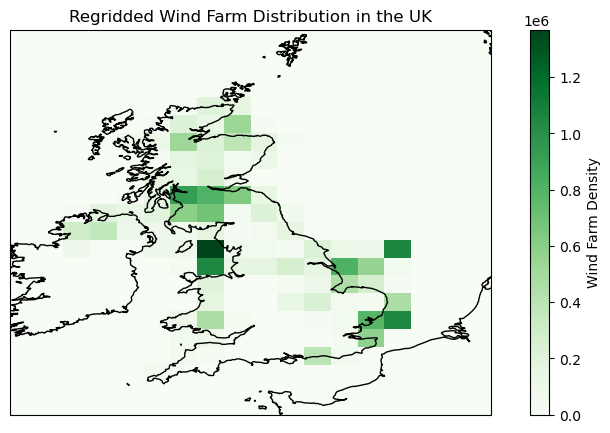

In [62]:
# -----------------------------------
# Plot the wind farm distribution
# -----------------------------------
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()

mesh = ax.pcolormesh(
    LONS, LATS, data_regrid,
    cmap="Greens",
    transform=ccrs.PlateCarree(),
)

# limit to the min/max lon/lat region
ax.set_extent([-10, 5, 49, 61], crs=ccrs.PlateCarree())

# include a title
plt.title("Regridded Wind Farm Distribution in the UK")

plt.colorbar(mesh, ax=ax, orientation="vertical", label="Wind Farm Density")

In [21]:
# -----------------------------------
# Extract the values from cube regrid
# -----------------------------------

si10_values = cube_regridded.data

In [22]:
np.max(MASK_MATRIX_RESHAPE)

np.float64(1.0)

In [23]:
print("Mean of si10_values:", np.mean(si10_values))
print("Minimum of si10_values:", np.min(si10_values))
print("Maximum of si10_values:", np.max(si10_values))

Mean of si10_values: 6.198307301453676
Minimum of si10_values: 0.0
Maximum of si10_values: 28.413857


In [24]:
# ------------------------------------------
# Load the wind speed and take to hub height
# ------------------------------------------


# data_u = iris.load(path_to_wind_speed, COND1)
# data_v = iris.load(path_to_wind_speed, COND2)
# equalised_cubes_u = iris.util.equalise_attributes(data_u)
# equalised_cubes_v = iris.util.equalise_attributes(data_v)
# conc_cubes_u = data_u.concatenate_cube()
# conc_cubes_v = data_v.concatenate_cube()

# # turn into 10m wind speed and get up to hub-height.
# speed = (conc_cubes_u * conc_cubes_u + conc_cubes_v * conc_cubes_v) ** 0.5
# print(speed)
# print("concatenating cubes")

speed = si10_values

height_of_wind_speed = 10.0  # height of wind speed in m
landmask = MASK_MATRIX_RESHAPE  # landmask from the country mask function

print(np.shape(speed)[0])

correction_hubheight = landmask * (71.0 / height_of_wind_speed) ** (
    1.0 / 7.0
) + abs(landmask - 1) * (92.0 / height_of_wind_speed) ** (1.0 / 7.0)

speed_hubheight = speed * correction_hubheight

# # load in the Global wind atlas 100m correction and apply.
# # have checked adding is right, as wind speeds are too low over orography...so need to add on the potitve bits in the array loaded here.
# GWA_correction = np.load(
#     "/home/users/hbloomfield01/CCC/process_ERA5/GWA_correction_factor_on_ERA5_grid.npy"
# )

# GWA_broadcast = iris.util.broadcast_to_shape(
#     GWA_correction, np.shape(speed_hubheight), (1, 2)
# )

# corrected_speed_hubheight = (
#     speed_hubheight + GWA_correction
# )  # add in the bias correction stage.

# speed_hubheight.rename("Hub Height Wind Speed")


731


In [25]:
speed_hubheight[0, :, :]

masked_array(
  data=[[6.791939693865581, 6.131527283103437, 5.2710750523608585, ...,
         9.122106092925463, 9.650277972688093, 9.62865657614224],
        [8.441337200168295, 7.773174896270452, 6.909126956049016, ...,
         7.938550688873214, 8.701032275952748, 9.785323314213361],
        [9.902946618369285, 9.369173628884944, 8.62001161821435, ...,
         9.78066368851033, 8.919641198671597, 4.718912352781437],
        ...,
        [5.604873693632408, 5.461722292555475, 5.444843016139878, ...,
         11.025017485429617, 11.067122379199718, 11.121896060008405],
        [6.320691587760978, 5.9430595980535985, 5.714677704578936, ...,
         10.229187853502003, 10.449927227539899, 10.574277101103288],
        [7.5168051315644995, 7.14204211471516, 6.6786813924583, ...,
         9.383045787012778, 9.896561156871233, 10.351418405946843]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, Fal

In [26]:
# print the mean of speed hub height
print(f"Mean wind speed at hub height: {np.mean(speed_hubheight)} m/s")

# print the min and max of speed hub height
print(f"Min wind speed at hub height: {np.min(speed_hubheight)} m/s")
print(f"Max wind speed at hub height: {np.max(speed_hubheight)} m/s")

Mean wind speed at hub height: 8.50853005969825 m/s
Min wind speed at hub height: 0.0 m/s
Max wind speed at hub height: 39.01343213239145 m/s


In [27]:
LONS

array([[  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299],
       [  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299],
       [  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299],
       ...,
       [  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299],
       [  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299],
       [  0.41666666,   1.25      ,   2.08333325, ..., 357.91665649,
        358.74996948, 359.58331299]])

In [28]:
LATS

array([[-89.72222137, -89.72222137, -89.72222137, ..., -89.72222137,
        -89.72222137, -89.72222137],
       [-89.16666412, -89.16666412, -89.16666412, ..., -89.16666412,
        -89.16666412, -89.16666412],
       [-88.61110687, -88.61110687, -88.61110687, ..., -88.61110687,
        -88.61110687, -88.61110687],
       ...,
       [ 88.61112213,  88.61112213,  88.61112213, ...,  88.61112213,
         88.61112213,  88.61112213],
       [ 89.16667938,  89.16667938,  89.16667938, ...,  89.16667938,
         89.16667938,  89.16667938],
       [ 89.72223663,  89.72223663,  89.72223663, ...,  89.72223663,
         89.72223663,  89.72223663]])

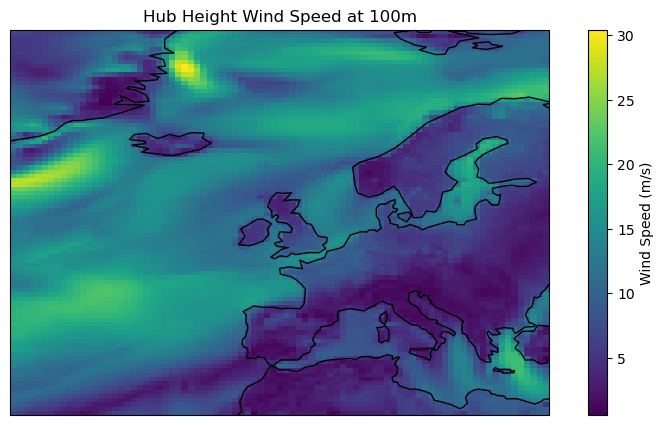

In [29]:
# ------------------------------------------
# Plot the first timestep of speed hubheight to check
# ------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

lats = cube_regridded.coord("latitude").points
lons = cube_regridded.coord("longitude").points


ax.coastlines()

mesh = ax.pcolormesh(
    lons, lats, speed_hubheight[0, :, :],
    cmap="viridis",
    transform=ccrs.PlateCarree(),
)

# # limit to the min/max lon/lat region
# ax.set_extent([-10, 5, 49, 61], crs=ccrs.PlateCarree())

# include a title
plt.title("Hub Height Wind Speed at 100m")

plt.colorbar(mesh, ax=ax, orientation="vertical", label="Wind Speed (m/s)")

In [30]:
%%time

speed_hubheight_vals = speed_hubheight.data

CPU times: user 8 μs, sys: 1 μs, total: 9 μs
Wall time: 13.8 μs


In [31]:
speed_hubheight_vals.shape

(731, 91, 85)

In [32]:
# set up the speed hubheight vals test
speed_hubheight_vals_test = speed_hubheight_vals[0, :, :]

In [34]:
speed_hubheight_test = speed_hubheight[0, :, :].copy()

In [35]:
regridded_windfarms_total_corrected.shape

(324, 432)

In [40]:
type(speed_hubheight)

numpy.ma.MaskedArray

In [55]:
type(landmask)

numpy.ndarray

In [56]:
type(regridded_windfarms_total_corrected)

iris.cube.Cube

In [57]:
regridded_windfarms_total_corrected.data.shape

(324, 432)

In [63]:
%%time

# -------------------------------
# Convert to wind power using the power curves
# -------------------------------

# Test the function for doing this
# WP_data = convert_to_wind_power(
#     pc_winds=pc_winds,
#     pc_power_onshore=pc_power_onshore,
#     pc_power_offshore=pc_power_offshore,
#     speed_hubheight=speed_hubheight,
#     regridded_windfarms_total_corrected=regridded_windfarms_total_corrected,
#     landmask=MASK_MATRIX_RESHAPE,
# )

test = np.digitize(
    speed_hubheight_vals_test, pc_winds, right=False
)  # indexing starts from 1 so needs -1: 0 in the next bit to start from the lowest bin.
test[test == len(pc_winds)] = 500  # make sure the bins don't go off the
# end (power is zero by then anyway)
# [time, lat, lon]

p_hh_temp1 = landmask * 0.5 * (pc_power_onshore[test - 1] + pc_power_onshore[test])

p_hh_temp2 = (
    abs(landmask - 1)
    * 0.5
    * (pc_power_offshore[test - 1] + pc_power_offshore[test])
)

p_hh_temp = p_hh_temp1 + p_hh_temp2

# get timeseries accumilated over country
phh_in_GW = (
    p_hh_temp * data_regrid
) / 1000.0  # get it in GW

# # Create a new cube with the same metadata but new data
# phh_cube = iris.cube.Cube(
#     phh_in_GW,  # New data
#     standard_name=speed_hubheight_test.standard_name,
#     long_name=speed_hubheight_test.long_name,
#     var_name=speed_hubheight_test.var_name,
#     units="%",  # Set the desired units
#     attributes=speed_hubheight_test.attributes,
#     dim_coords_and_dims=speed_hubheight_test.dim_coords_and_dims,
#     aux_coords_and_dims=speed_hubheight_test.aux_coords_and_dims,
# )

# # rename the cube in preparation for conversion to CF later.
# phh_cube.rename("Wind Power Capacity factor")
# phh_cube.units = "%"

CPU times: user 1.1 ms, sys: 0 ns, total: 1.1 ms
Wall time: 615 μs


In [64]:
phh_in_GW.shape

(91, 85)

In [65]:
phh_in_GW

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

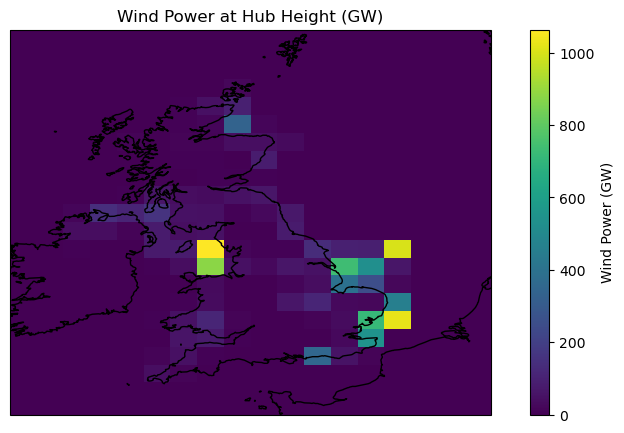

In [ ]:
# ------------------------------------------
# plot the power hub height data in GW
# ------------------------------------------

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

lats = cube_regridded.coord("latitude").points
lons = cube_regridded.coord("longitude").points

ax.coastlines()

mesh = ax.pcolormesh(
    lons, lats, phh_in_GW,
    cmap="Blues",
    transform=ccrs.PlateCarree(),
)

# Min latitude: 50.27777862548828, Max latitude: 59.72223663330078
# Min longitude: -6.250030517578125, Max longitude: 4.5833330154418945
constraint_lon = (-6.25, 4.58)  # degrees east
constraint_lat = (50.28, 59.72)  # degrees north

# # limit to the min/max lon/lat region
ax.set_extent(
    [constraint_lon[0], constraint_lon[1], constraint_lat[0], constraint_lat[1]],
    crs=ccrs.PlateCarree(),
)

# include a title
plt.title("Wind Power at Hub Height (GW)")

plt.colorbar(mesh, ax=ax, orientation="vertical", label="Wind Power (GW)")

In [68]:
# Get the sum of the wind power across the UK
total_wind_power_uk = np.sum(phh_in_GW)

In [69]:
print(f"Total wind power across the UK: {total_wind_power_uk:.2f} GW")

Total wind power across the UK: 11617.85 GW


In [70]:
WP_cf_timeseries = (total_wind_power_uk / 1000.0) / (np.sum(regridded_windfarms_total_corrected) / 1000000)

In [ ]:

WP_country_level = phh_cube.collapsed(["latitude", "longitude"], iris.analysis.SUM)
# turn into CF by dividing by the total installed CF.